<a href="https://colab.research.google.com/github/eeanthonio1411/CFO_estimation_CIR/blob/main/11102025_TxOffset_CFO_estimation_CIR_rooftops.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pylfsr

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import os
import math
from scipy.signal import convolve
# NOTE: Ensure 'pylfsr' is installed for packet generation
from pylfsr import LFSR

# Configuration
samp_rate = 2_500_000.0  # 2.5 MHz sample rate

# ----------------- Utility Functions -----------------

def load_signals():
    """Load received signal only"""
    rx_signal = np.fromfile('rx_output.dat', dtype=np.complex64)
    print(f"RX Signal length: {len(rx_signal)} samples")
    print(f"RX Signal duration: {len(rx_signal)/samp_rate*1000:.2f} ms")
    return rx_signal


def visualize_signals(tx_signal, rx_signal):
    """Visualize TX and RX signals in time domain"""
    fig, axes = plt.subplots(3, 1, figsize=(14, 10))
    t_tx = np.arange(len(tx_signal)) / samp_rate * 1000
    axes[0].plot(t_tx, np.real(tx_signal), 'b-', alpha=0.7, label='Real', linewidth=0.5)
    axes[0].plot(t_tx, np.imag(tx_signal), 'r-', alpha=0.7, label='Imag', linewidth=0.5)
    axes[0].set_ylabel('Amplitude'); axes[0].set_title('Transmitted Signal'); axes[0].legend(); axes[0].grid(True, alpha=0.3)
    t_rx = np.arange(len(rx_signal)) / samp_rate * 1000
    axes[1].plot(t_rx, np.real(rx_signal), 'b-', alpha=0.7, label='Real', linewidth=0.5)
    axes[1].plot(t_rx, np.imag(rx_signal), 'r-', alpha=0.7, label='Imag', linewidth=0.5)
    axes[1].set_ylabel('Amplitude'); axes[1].set_title('Received Signal (Full)'); axes[1].legend(); axes[1].grid(True, alpha=0.3)
    axes[2].plot(t_rx, np.abs(rx_signal), 'g-', linewidth=0.5)
    axes[2].set_xlabel('Time (ms)'); axes[2].set_ylabel('Magnitude'); axes[2].set_title('Received Signal Magnitude'); axes[2].grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('signal_visualization.png', dpi=150, bbox_inches='tight')
    print("Saved: signal_visualization.png")
    plt.show()


def cross_correlation_analysis(rx_signal, preamble_signal, selected_lag=None):
    """Perform cross-correlation to find preamble in received signal"""
    preamble_signal = np.asarray(preamble_signal).ravel()
    rx_signal = np.asarray(rx_signal).ravel()
    print(f"\nDebug - Cross-correlation input shapes:\n  RX signal shape: {rx_signal.shape}\n  Preamble signal shape: {preamble_signal.shape}")
    lags = signal.correlation_lags(len(rx_signal), len(preamble_signal), mode='same')
    xcorr_out = signal.correlate(rx_signal, preamble_signal, mode='same')
    xcorr_mag = np.abs(xcorr_out)
    length_of_packet = len(preamble_signal) + 3200
    peak_threshold = 0.6 * np.max(xcorr_mag)
    peaks, properties = signal.find_peaks(xcorr_mag, height=peak_threshold, distance=length_of_packet)
    sorted_indices = np.argsort(xcorr_mag[peaks])[::-1]
    sorted_peaks = peaks[sorted_indices]
    peak_lags = lags[sorted_peaks]
    print(f"\nFound {len(peaks)} packet(s) in received signal (Threshold: {peak_threshold:.4f})")
    for i, (peak_idx, lag) in enumerate(zip(sorted_peaks, peak_lags)):
        print(f"  Packet {i+1} (Sorted): lag = {lag}, correlation = {xcorr_mag[peak_idx]:.4f}")
    maxIndex = sorted_peaks[0] if len(sorted_peaks) > 0 else np.argmax(xcorr_mag[:len(xcorr_mag)-length_of_packet])
    lagIndex = lags[maxIndex]
    plot_lag = selected_lag if selected_lag is not None else lagIndex
    print(f"\nSelected lag for analysis (lagIndex): {plot_lag}")

    # Plotting...
    fig, axes = plt.subplots(3, 1, figsize=(14, 10))
    axes[0].plot(lags, xcorr_mag, 'b-', linewidth=0.8); axes[0].plot(peak_lags, xcorr_mag[sorted_peaks], 'ro', markersize=8, label='Detected Packets')
    if selected_lag is not None:
        selected_idx = np.argmin(np.abs(lags - selected_lag))
        axes[0].plot(selected_lag, xcorr_mag[selected_idx], 'g*', markersize=15, label='Selected Best Packet', zorder=10)
    axes[0].axhline(y=peak_threshold, color='r', linestyle='--', alpha=0.5, label='Threshold')
    axes[0].set_title('Cross-Correlation Magnitude - All Packets'); axes[0].legend(); axes[0].grid(True, alpha=0.3)

    preamble_len = len(preamble_signal)
    start_idx = plot_lag; end_idx = min(start_idx + preamble_len, len(rx_signal))
    short_t = np.arange(start_idx, end_idx)
    if len(short_t) > 0:
        preamble_segment = preamble_signal[:len(short_t)]
        scale_factor = np.mean(np.abs(rx_signal[short_t])) / np.mean(np.abs(preamble_segment))
        axes[1].plot(short_t, np.real(rx_signal[short_t]), 'b-', label='Real RX', linewidth=1)
        axes[1].plot(short_t, scale_factor*np.real(preamble_segment), 'g--', label='Real Preamble (scaled)', linewidth=1.5, alpha=0.7)
        axes[1].set_title(f'RX vs Preamble (lag={plot_lag})'); axes[1].legend(); axes[1].grid(True, alpha=0.3)
        rx_phase = np.angle(rx_signal[short_t])
        preamble_phase = np.angle(preamble_segment)
        axes[2].plot(short_t, rx_phase, 'b-', label='RX Phase', linewidth=1)
        axes[2].plot(short_t, preamble_phase, 'g--', label='Preamble Phase', linewidth=1.5, alpha=0.7)
        axes[2].set_xlabel('Sample Index'); axes[2].set_ylabel('Phase (radians)'); axes[2].set_title('Phase Comparison'); axes[2].legend(); axes[2].grid(True, alpha=0.3)

    plt.tight_layout(); plt.savefig('cross_correlation_analysis.png', dpi=150, bbox_inches='tight'); print("Saved: cross_correlation_analysis.png"); plt.show()
    return lagIndex, peak_lags


def plot_zoomed_frequency_offset(freqRange, PSD_prod, maxIndexFreq, maxIndexPSD, samp_rate, filename='frequency_offset_zoomed.png'):
    """Generates a zoomed plot around the detected frequency peak."""
    peak_hz = maxIndexFreq * samp_rate

    # Define a window around the peak: e.g., ± 50 kHz
    zoom_span = 50e3 # 50 kHz
    zoom_min_hz = peak_hz - zoom_span
    zoom_max_hz = peak_hz + zoom_span

    # Convert zoom limits back to normalized frequency indices
    zoom_min_norm = zoom_min_hz / samp_rate
    zoom_max_norm = zoom_max_hz / samp_rate

    # Find the corresponding indices in the full array
    freq_hz = samp_rate * freqRange
    start_idx = np.searchsorted(freqRange, zoom_min_norm)
    end_idx = np.searchsorted(freqRange, zoom_max_norm)

    # Ensure indices are within bounds
    start_idx = max(0, start_idx)
    end_idx = min(len(freqRange), end_idx)

    # Slice the arrays for the zoomed view
    zoomed_freq_hz = freq_hz[start_idx:end_idx]
    zoomed_PSD = PSD_prod[start_idx:end_idx]

    plt.figure(figsize=(10, 5))
    plt.plot(zoomed_freq_hz, zoomed_PSD, 'b-', linewidth=1)

    # Plot the peak again (ensure the peak is within the zoomed range)
    if start_idx <= maxIndexPSD < end_idx:
        plt.plot([peak_hz], [PSD_prod[maxIndexPSD]], 'ro',
                 markersize=10, label=f'Peak: {peak_hz:.2f} Hz')

    plt.grid(True, alpha=0.3)
    plt.xlabel('Frequency Offset (Hz)')
    plt.ylabel('PSD (Zoomed)')
    plt.title(f'Frequency Offset Estimation - Zoomed (Peak: {peak_hz:.2f} Hz)')
    plt.legend()
    plt.tight_layout()
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    print(f"Saved: {filename}")
    plt.show()


def estimate_frequency_offset(rx_signal, tx_packet, lagIndex, debug=True):
    """Estimate frequency offset using PN code (full payload after preamble)"""
    tx_packet = np.asarray(tx_packet).ravel()
    rx_signal = np.asarray(rx_signal).ravel()

    # Extract PN code portion (skip preamble)
    preamble_length = 256
    discardSamples = 100  # Skip edge effects

    pn_code = tx_packet[preamble_length + discardSamples:]
    N = len(pn_code)

    # Extract corresponding RX segment
    startInd = max(0, lagIndex + preamble_length + discardSamples)
    if startInd + N > len(rx_signal):
        N = len(rx_signal) - startInd
        pn_code = pn_code[:N]

    rx0_part = np.conjugate(rx_signal[startInd:(startInd + N)])
    prod_rx0_preamble = rx0_part * pn_code

    print(f"\nFrequency estimation using PN code:")
    print(f"  PN code length: {N} samples ({N/samp_rate*1000:.2f} ms)")
    print(f"  Frequency resolution: {samp_rate/N:.2f} Hz")

    # Ultra-wide search range: 1.0 (±2.5 MHz)
    maxFreqOffset = 0.005000
    deltaFreqOffset = 0.000005
    freqRange = np.arange(-maxFreqOffset, maxFreqOffset, deltaFreqOffset)

    # Robust PSD calculation
    temp = (-1j * 2 * np.pi) * freqRange
    time_indices = np.arange(0, N)
    expMat = np.exp(np.outer(temp, time_indices))
    cross_spectral_density = expMat @ prod_rx0_preamble
    PSD_prod = np.abs(cross_spectral_density)**2

    # Find maximum
    maxIndexPSD = np.argmax(PSD_prod)
    maxIndexFreq = freqRange[maxIndexPSD]

    print(f'\nFrequency offset estimate: {maxIndexFreq * samp_rate:.2f} Hz')
    print(f'Normalized frequency offset: {maxIndexFreq:.6f}')

    if debug:
        # 1. Plot Full Spectrum
        plt.figure(figsize=(12, 5))
        freq_hz = samp_rate * freqRange
        plt.plot(freq_hz, PSD_prod, 'b-', linewidth=1)
        plt.plot([samp_rate * maxIndexFreq], [PSD_prod[maxIndexPSD]], 'ro',
                 markersize=10, label=f'Peak: {maxIndexFreq * samp_rate:.2f} Hz')
        plt.grid(True, alpha=0.3); plt.xlabel('Frequency Offset (Hz)'); plt.ylabel('PSD');
        plt.title('Frequency Offset Estimation (Full Spectrum)'); plt.legend(); plt.tight_layout()
        plt.savefig('frequency_offset_estimation_full.png', dpi=150, bbox_inches='tight');
        print("Saved: frequency_offset_estimation_full.png"); plt.show()

        # 2. Plot Zoomed Spectrum
        plot_zoomed_frequency_offset(freqRange, PSD_prod, maxIndexFreq, maxIndexPSD, samp_rate, 'frequency_offset_estimation_zoomed.png')

    return maxIndexFreq


def correct_frequency_offset(rx_signal, maxIndexFreq):
    """Apply frequency offset correction"""
    expTerm = np.exp((1j * 2 * np.pi * maxIndexFreq) * np.arange(len(rx_signal)))
    rx_corrected = expTerm * rx_signal
    print("Frequency offset corrected")
    return rx_corrected


In [ ]:
def analyze_channel_impulse_response(tx_signal, rx_corrected, lagIndex, regenerate_packet=False):
    """Estimate and analyze channel impulse response"""
    tx_packet = tx_signal
    preamble_length = 256
    tx_payload = tx_packet[preamble_length:]
    rx_start = lagIndex + preamble_length
    cir_estimation_length = 4096
    tx_packet_used = tx_payload[:cir_estimation_length]
    if rx_start + cir_estimation_length > len(rx_corrected):
        cir_estimation_length = len(rx_corrected) - rx_start
        tx_packet_used = tx_payload[:cir_estimation_length]
    rx_packet = rx_corrected[rx_start:rx_start + cir_estimation_length]
    if len(tx_packet_used) != len(rx_packet):
         min_len = min(len(tx_packet_used), len(rx_packet))
         tx_packet_used = tx_packet_used[:min_len]; rx_packet = rx_packet[:min_len]

    print(f"\nChannel estimation using:\n  TX payload length: {len(tx_packet_used)} samples ({len(tx_packet_used)/samp_rate*1000:.2f} ms)\n  RX payload length: {len(rx_packet)} samples ({len(rx_packet)/samp_rate*1000:.2f} ms)")

    tx_power = np.mean(np.abs(tx_packet_used)**2); rx_power = np.mean(np.abs(rx_packet)**2); eps = 1e-10
    if tx_power > 0 and rx_power > 0:
        path_gain_db = 10*np.log10(rx_power / tx_power)
        print(f"  Path loss: {-path_gain_db:.2f} dB")
        print(f"  Tx Power (mean): {tx_power:.8f}")
        print(f"  Rx Power (mean): {rx_power:.8f}")
    else:
        print(f"  Path loss: Cannot compute (TX or RX power is zero)")

    TX_fft = np.fft.fft(tx_packet_used); RX_fft = np.fft.fft(rx_packet); tx_fft_power = np.abs(TX_fft)
    threshold = np.max(tx_fft_power) * 0.05
    H_fft = np.where(tx_fft_power > threshold, RX_fft / (TX_fft + eps), 0)
    h_time = np.fft.ifft(H_fft); num_taps = 200; h_time_short = h_time[:num_taps]

    # Calculate Metrics
    max_mag_idx = np.argmax(np.abs(h_time_short))
    estimated_distance_m = (max_mag_idx / samp_rate) * 3.0e8
    signal_taps = np.abs(h_time_short[:50])**2; noise_taps = np.abs(h_time_short[100:])**2
    snr_estimate = 10 * np.log10(np.sum(signal_taps) / (np.mean(noise_taps) * len(h_time_short) + eps)) if len(noise_taps) > 0 and np.mean(noise_taps) > 0 else 0

    print(f"\nChannel Impulse Response Analysis:\n  Max tap magnitude: {np.max(np.abs(h_time_short)):.4f}\n  Peak tap location: {max_mag_idx} samples\n  Estimated distance (based on peak tap): {estimated_distance_m:.1f} meters")
    print(f"  RMS delay spread: {calculate_rms_delay_spread(h_time_short):.2f} samples")
    print(f"  Estimated SNR from CIR: {snr_estimate:.2f} dB")

    # --- Plotting (3 rows, 2 columns) ---
    fig, axes = plt.subplots(3, 2, figsize=(14, 12))

    # 0, 0: Full CIR Magnitude (Main Plot)
    axes[0, 0].stem(np.abs(h_time_short), linefmt='b-', markerfmt='bo', basefmt='k-')
    axes[0, 0].set_xlabel('Delay (Samples)'); axes[0, 0].set_ylabel('Magnitude (Relative Tap Strength)')
    axes[0, 0].set_title('Channel Impulse Response - Magnitude (Full 200 taps)'); axes[0, 0].grid(True, alpha=0.3)

    # 0, 1: Zoomed CIR Magnitude (First 10 Taps)
    zoom_taps = 10
    axes[0, 1].stem(np.abs(h_time_short[:zoom_taps]), linefmt='b-', markerfmt='bo', basefmt='k-')
    axes[0, 1].set_xlabel('Delay (Samples)'); axes[0, 1].set_ylabel('Magnitude (Zoomed)'); axes[0, 1].set_title(f'CIR - Zoomed to First {zoom_taps} Taps'); axes[0, 1].grid(True, alpha=0.3)

    # 1, 0: Frequency response - magnitude
    freqs = np.fft.fftfreq(len(H_fft), 1/samp_rate) / 1e6
    axes[1, 0].plot(freqs[:len(freqs)//2], 20*np.log10(np.abs(H_fft[:len(H_fft)//2])+eps), 'b-')
    axes[1, 0].set_xlabel('Frequency (MHz)'); axes[1, 0].set_ylabel('Magnitude (dB)'); axes[1, 0].set_title('Channel Frequency Response - Magnitude'); axes[1, 0].grid(True, alpha=0.3)

    # 1, 1: Frequency response - phase
    axes[1, 1].plot(freqs[:len(freqs)//2], np.angle(H_fft[:len(freqs)//2]), 'r-')
    axes[1, 1].set_xlabel('Frequency (MHz)'); axes[1, 1].set_ylabel('Phase (radians)'); axes[1, 1].set_title('Channel Frequency Response - Phase'); axes[1, 1].grid(True, alpha=0.3)

    # 2, 0: Power delay profile
    pdp = np.abs(h_time_short)**2
    pdp_db = 10 * np.log10(pdp / np.max(pdp) + eps)
    axes[2, 0].plot(pdp_db, 'b-', linewidth=1.5)
    axes[2, 0].set_xlabel('Tap Index'); axes[2, 0].set_ylabel('Power (dB)'); axes[2, 0].set_title('Power Delay Profile'); axes[2, 0].grid(True, alpha=0.3); axes[2, 0].set_ylim([-40, 0])

    # 2, 1: Constellation comparison
    axes[2, 1].scatter(np.real(tx_packet_used[:1000]), np.imag(tx_packet_used[:1000]),
                        alpha=0.3, s=10, label='TX', c='blue')
    axes[2, 1].scatter(np.real(rx_packet[:1000]), np.imag(rx_packet[:1000]),
                        alpha=0.3, s=10, label='RX (corrected)', c='red')
    axes[2, 1].set_xlabel('In-phase'); axes[2, 1].set_ylabel('Quadrature')
    axes[2, 1].set_title('Constellation Diagram'); axes[2, 1].legend()
    axes[2, 1].grid(True, alpha=0.3); axes[2, 1].axis('equal')

    plt.tight_layout()
    plt.savefig('channel_impulse_response.png', dpi=150, bbox_inches='tight')
    plt.show()

    return h_time_short, H_fft


def extract_best_packet(rx_signal, all_lags, tx_packet_length):
    """Analyzes all detected packet lags and returns the lag index of the strongest one."""
    if len(all_lags) == 0: return 0
    if len(all_lags) == 1: return all_lags[0]
    print(f"\n{len(all_lags)} packets detected. Analyzing packet quality...")
    packet_powers = []
    for i, lag in enumerate(all_lags):
        start = lag; end = min(lag + tx_packet_length, len(rx_signal))
        packet_segment = rx_signal[start:end]
        power = np.mean(np.abs(packet_segment)**2) if len(packet_segment) > 0 else 0
        packet_powers.append(power)
        print(f"  Packet {i+1} at lag {lag}: Power = {power:.6f}")
    best_packet_idx = np.argmax(packet_powers)
    best_lag = all_lags[best_packet_idx]
    print(f"\n✓ Selected packet {best_packet_idx+1} (strongest) at lag {best_lag}")
    return best_lag


def generate_reference_bpsk_packet(samp_rate=2_500_000.0):
    """
    Generate a reference BPSK packet matching the transmission parameters.
    Preamble length 256 samples, Payload repeated 20 times.
    """
    import math; from scipy.signal import convolve

    # --- HARDCODED PARAMETERS (Matching BPSK_Generator defaults) ---
    N_stages = 10
    taps = [10, 7]
    state = [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
    samples_per_chip = 4
    alpha = 0.25
    A = math.sqrt(9/2)
    Lp = 6
    pad_zeros = 1024

    # --- NEW LENGTHS ---
    numPN = 20 # INCREASED: Repeat payload 20 times
    preamble_alternating_chips = 128 # INCREASED: 4x increase (256 samples)

    # Generate PN sequence using LFSR
    L = LFSR(initstate=state, fpoly=taps); pn_seq = np.array(L.getFullPeriod(), dtype=int); L_codelen = len(pn_seq)
    symbols = np.where(pn_seq == 0, -A, A).astype(float); x_s = np.zeros(symbols.size * samples_per_chip, dtype=float); x_s[samples_per_chip-1::samples_per_chip] = symbols

    # Generate SRRC pulse
    ntemp = np.arange(-samples_per_chip*Lp, samples_per_chip*Lp+1, dtype=float); n = ntemp + 1e-9; coeff = 1/math.sqrt(samples_per_chip)
    cosine_coeff = 4 * alpha * n / samples_per_chip; numerator = np.sin(math.pi * n * (1 - alpha) / samples_per_chip) + cosine_coeff * np.cos(math.pi * n * (1 + alpha) / samples_per_chip)
    denom_coeff = math.pi * n / samples_per_chip; denom_part = 1 - cosine_coeff**2; pulse = coeff * (numerator / (denom_coeff * denom_part))

    shaped = convolve(x_s, pulse, mode="full"); P = len(pulse) - 1; oversamp_len = samples_per_chip * L_codelen

    # --- Payload Repetition (20x longer payload) ---
    payload = np.zeros(oversamp_len * numPN + P, dtype=shaped.dtype)
    for i in range(numPN):
        start = i * oversamp_len
        payload[start:start + oversamp_len + P] += shaped

    if pad_zeros > 0:
        payload = np.hstack([np.zeros(pad_zeros, dtype=payload.dtype), payload])

    # --- Preamble (4x longer preamble) ---
    preamble = np.array([A, -A] * preamble_alternating_chips, dtype=float)

    # --- Final Assembly ---
    packet = np.concatenate([0.3 * preamble, payload]).astype(np.complex64)
    print(f"  Preamble length: {len(preamble)} samples (256)")
    print(f"  Payload length: {len(payload)} samples ({len(payload)})")
    print(f"  Total packet length: {len(packet)} samples ({len(packet)})")

    return packet


def calculate_rms_delay_spread(h_time):
    """Calculate RMS delay spread"""
    power = np.abs(h_time)**2; power = power / np.sum(power)
    delays = np.arange(len(h_time)); mean_delay = np.sum(delays * power)
    rms_delay = np.sqrt(np.sum((delays - mean_delay)**2 * power))
    return rms_delay

Signal Analysis & Channel Estimation
  Preamble length: 256 samples (256)
  Payload length: 82912 samples (82912)
  Total packet length: 83168 samples (83168)
RX Signal length: 4158400 samples
RX Signal duration: 1663.36 ms

Step 1: Visualizing Signals


/tmp/ipython-input-4153292501.py:36: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/tmp/ipython-input-4153292501.py:37: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('signal_visualization.png', dpi=150, bbox_inches='tight')


Saved: signal_visualization.png


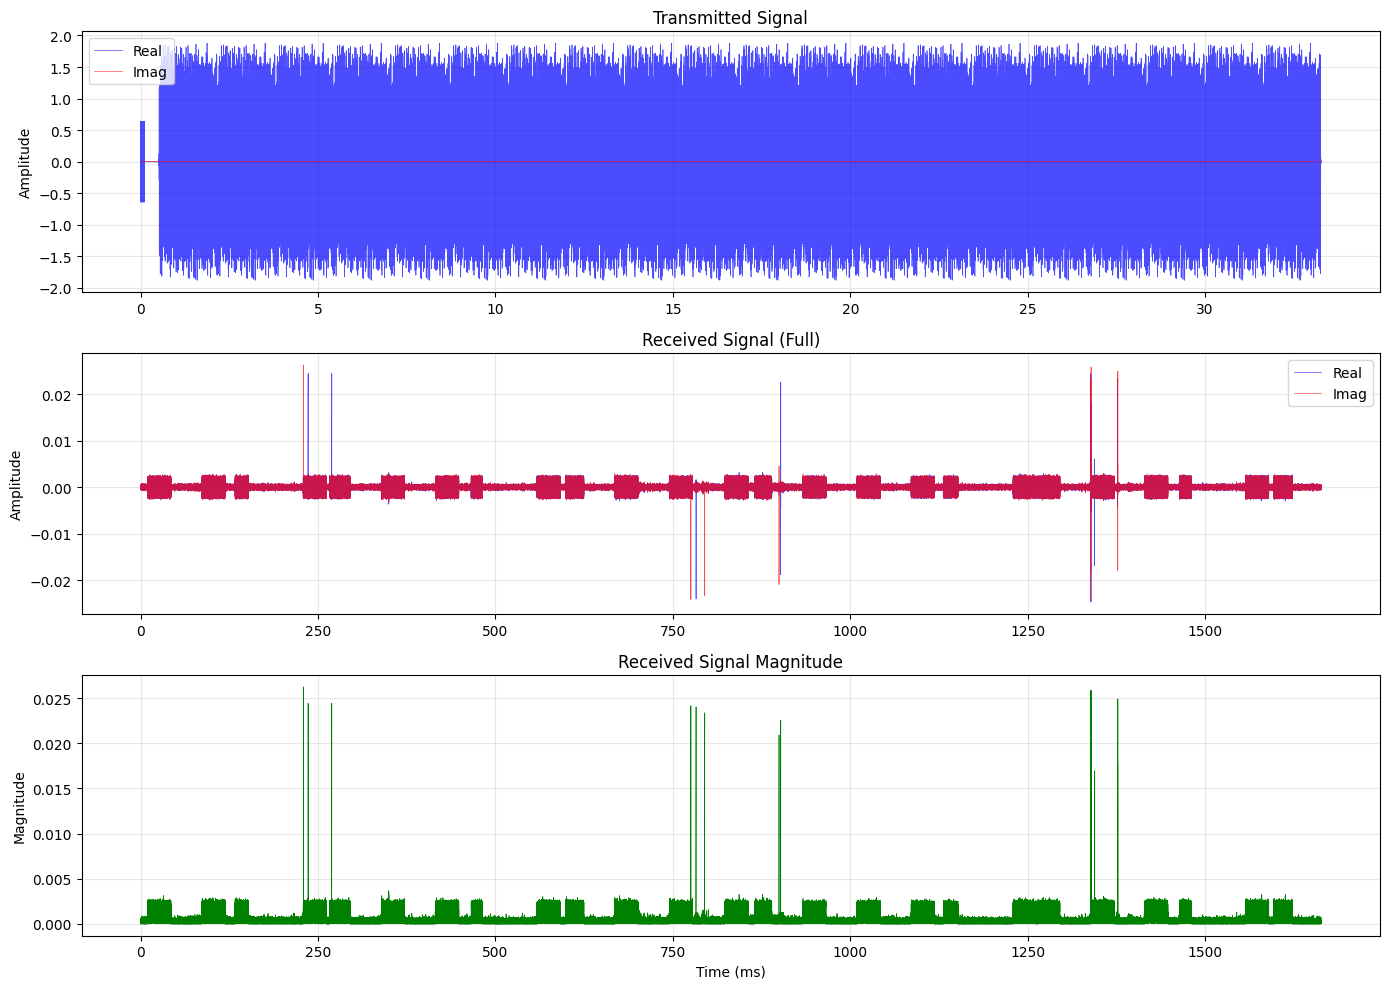


Step 2: Cross-Correlation Analysis - Find ALL packets

Debug - Cross-correlation input shapes:
  RX signal shape: (4158400,)
  Preamble signal shape: (256,)

Found 10 packet(s) in received signal (Threshold: 0.0546)
  Packet 1 (Sorted): lag = 2331405, correlation = 0.0910
  Packet 2 (Sorted): lag = 1861151, correlation = 0.0882
  Packet 3 (Sorted): lag = 1669062, correlation = 0.0834
  Packet 4 (Sorted): lag = 214182, correlation = 0.0812
  Packet 5 (Sorted): lag = 1037619, correlation = 0.0806
  Packet 6 (Sorted): lag = 3891229, correlation = 0.0783
  Packet 7 (Sorted): lag = 2057035, correlation = 0.0740
  Packet 8 (Sorted): lag = 23621, correlation = 0.0681
  Packet 9 (Sorted): lag = 1395011, correlation = 0.0620
  Packet 10 (Sorted): lag = 3535759, correlation = 0.0563

Selected lag for analysis (lagIndex): 2331405


/tmp/ipython-input-4153292501.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout(); plt.savefig('cross_correlation_analysis.png', dpi=150, bbox_inches='tight'); print("Saved: cross_correlation_analysis.png"); plt.show()


Saved: cross_correlation_analysis.png


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


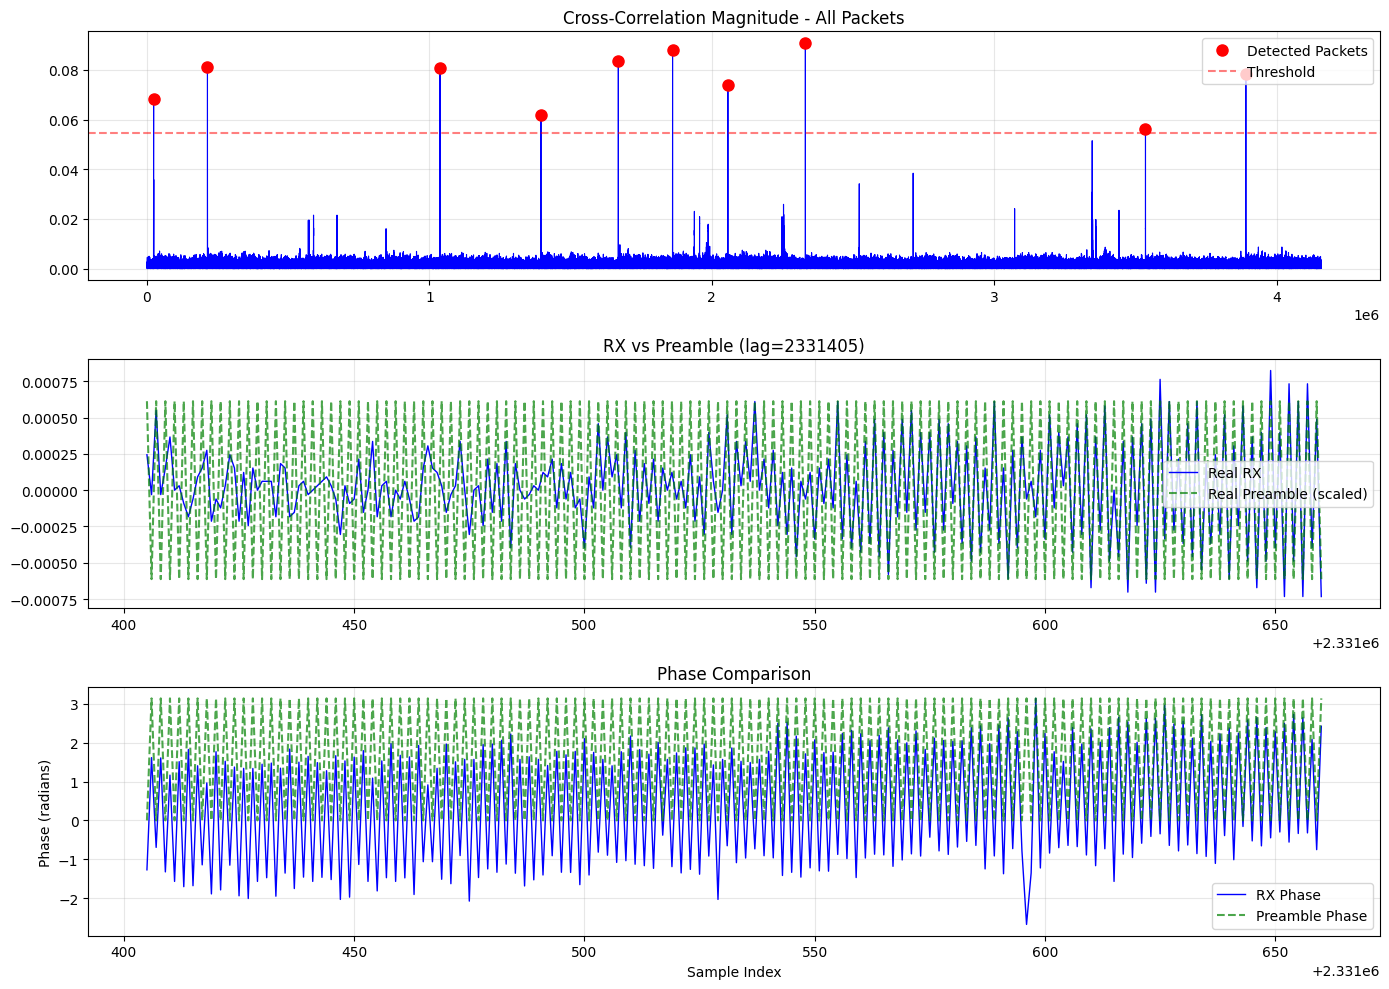


10 packets detected. Analyzing packet quality...
  Packet 1 at lag 2331405: Power = 0.000002
  Packet 2 at lag 1861151: Power = 0.000002
  Packet 3 at lag 1669062: Power = 0.000002
  Packet 4 at lag 214182: Power = 0.000002
  Packet 5 at lag 1037619: Power = 0.000002
  Packet 6 at lag 3891229: Power = 0.000002
  Packet 7 at lag 2057035: Power = 0.000002
  Packet 8 at lag 23621: Power = 0.000002
  Packet 9 at lag 1395011: Power = 0.000002
  Packet 10 at lag 3535759: Power = 0.000002

✓ Selected packet 6 (strongest) at lag 3891229

Re-plotting CC with best packet highlighted...

Debug - Cross-correlation input shapes:
  RX signal shape: (4158400,)
  Preamble signal shape: (256,)

Found 10 packet(s) in received signal (Threshold: 0.0546)
  Packet 1 (Sorted): lag = 2331405, correlation = 0.0910
  Packet 2 (Sorted): lag = 1861151, correlation = 0.0882
  Packet 3 (Sorted): lag = 1669062, correlation = 0.0834
  Packet 4 (Sorted): lag = 214182, correlation = 0.0812
  Packet 5 (Sorted): lag = 

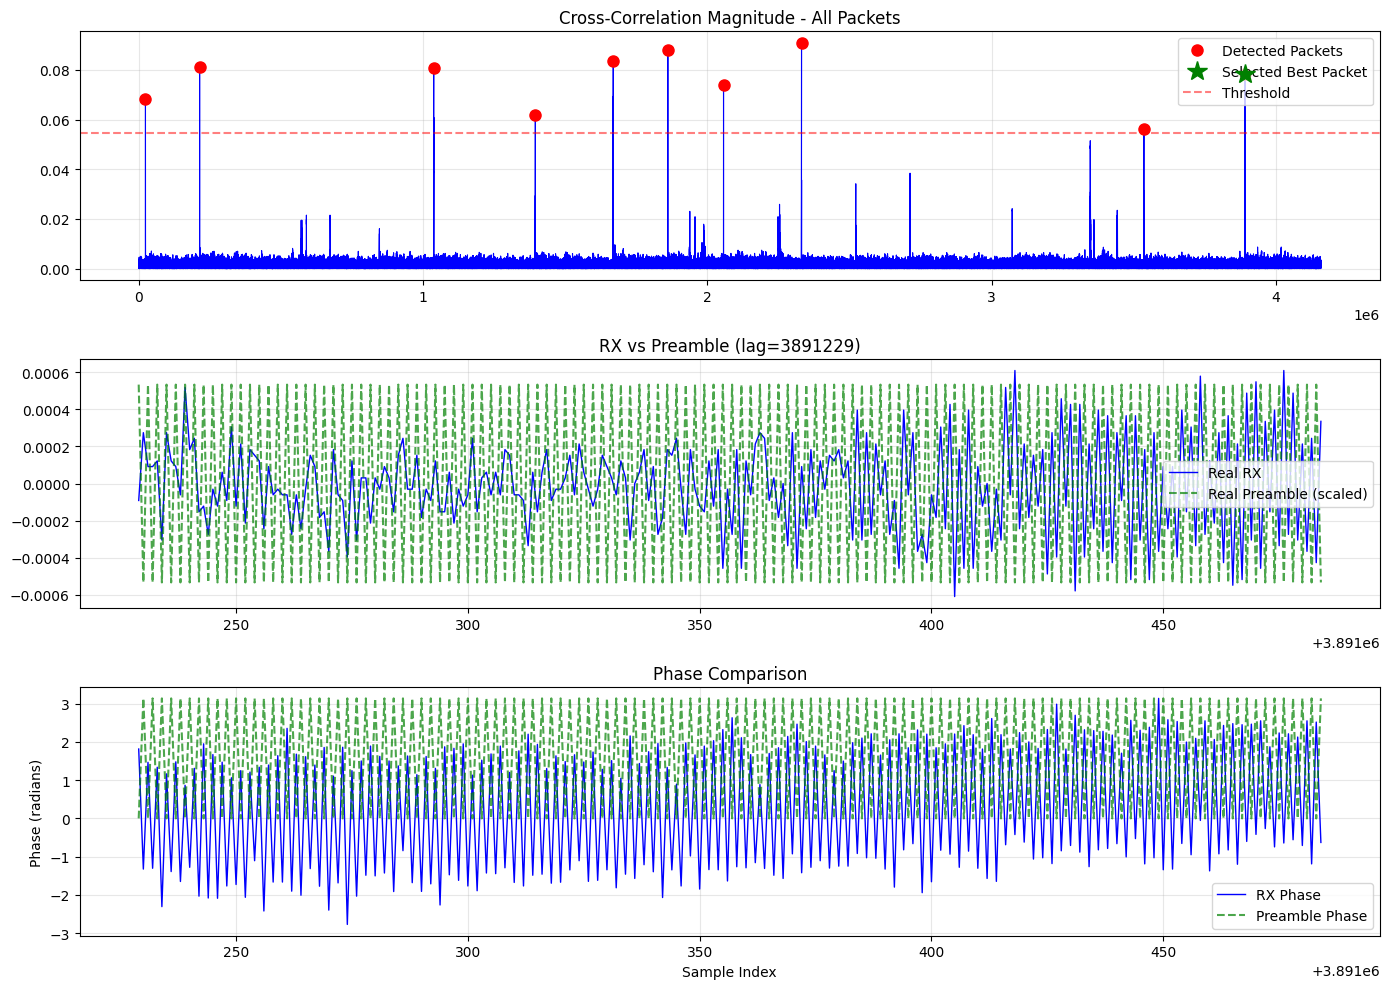


Step 3: Frequency Offset Estimation (using best lag 3891229)

Frequency estimation using PN code:
  PN code length: 82812 samples (33.12 ms)
  Frequency resolution: 30.19 Hz

Frequency offset estimate: -1912.50 Hz
Normalized frequency offset: -0.000765
Saved: frequency_offset_estimation_full.png


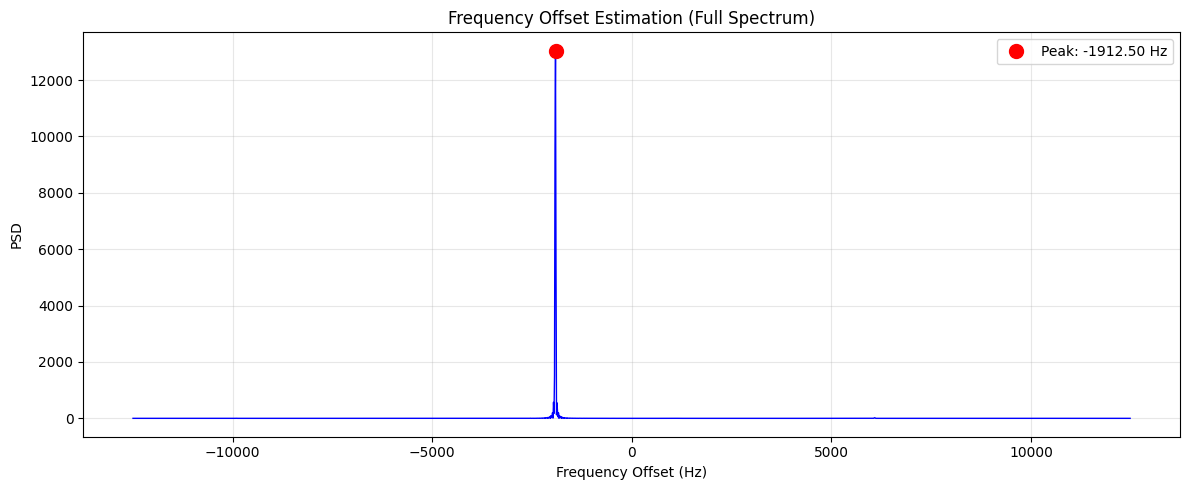

Saved: frequency_offset_estimation_zoomed.png


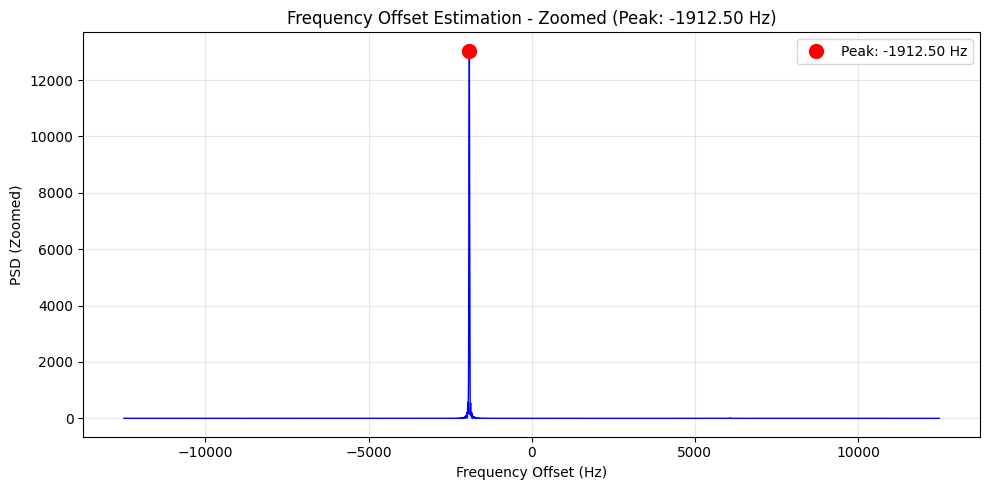


Step 4: Frequency Offset Correction
Frequency offset corrected

Step 4b: Constellation Verification
Saved: constellation_verification.png

***CRITICAL CHECK***: The constellation must show two tight clusters.


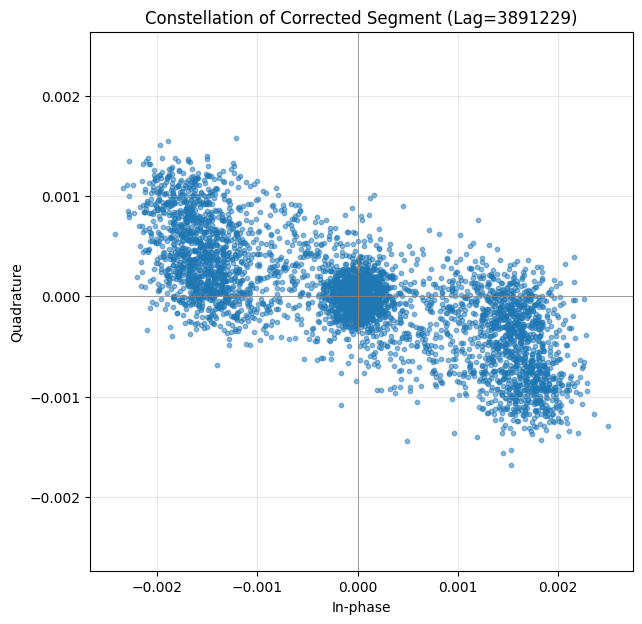


Step 5: Channel Impulse Response Analysis

Channel estimation using:
  TX payload length: 4096 samples (1.64 ms)
  RX payload length: 4096 samples (1.64 ms)
  Path loss: 56.55 dB
  Tx Power (mean): 0.83656108
  Rx Power (mean): 0.00000185

Channel Impulse Response Analysis:
  Max tap magnitude: 0.0004
  Peak tap location: 1 samples
  Estimated distance (based on peak tap): 120.0 meters
  RMS delay spread: 16.71 samples
  Estimated SNR from CIR: 16.34 dB


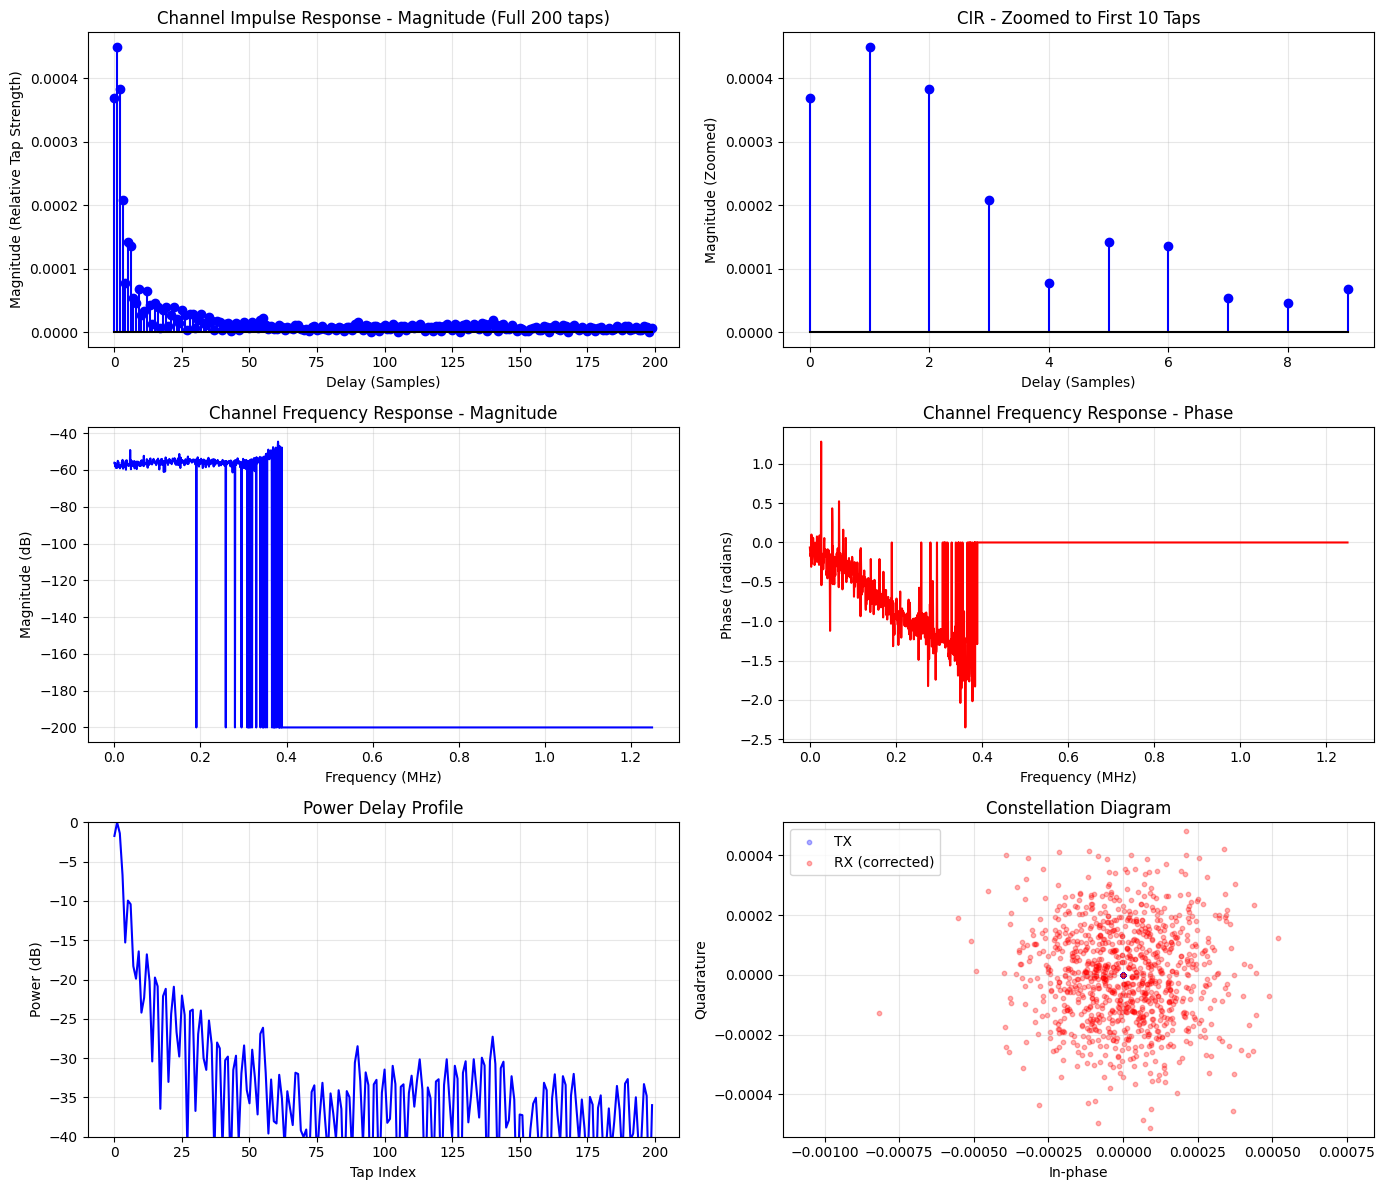


Analysis Complete!


In [ ]:
# ----------------- Main Function -----------------

def main():
    print("="*60); print("Signal Analysis & Channel Estimation"); print("="*60)
    tx_signal = generate_reference_bpsk_packet(samp_rate=samp_rate)
    rx_signal = load_signals()

    print("\n" + "="*60); print("Step 1: Visualizing Signals"); print("="*60)
    visualize_signals(tx_signal, rx_signal)

    print("\n" + "="*60); print("Step 2: Cross-Correlation Analysis - Find ALL packets"); print("="*60)
    preamble_length = 256
    preamble_signal = tx_signal[:preamble_length].copy().ravel()
    lagIndex_initial, all_lags = cross_correlation_analysis(rx_signal, preamble_signal)
    lagIndex = extract_best_packet(rx_signal, all_lags, len(tx_signal))

    print("\nRe-plotting CC with best packet highlighted...")
    cross_correlation_analysis(rx_signal, preamble_signal, selected_lag=lagIndex)

    print("\n" + "="*60); print(f"Step 3: Frequency Offset Estimation (using best lag {lagIndex})"); print("="*60)
    freq_offset = estimate_frequency_offset(rx_signal, tx_signal, lagIndex)

    print("\n" + "="*60); print("Step 4: Frequency Offset Correction"); print("="*60)
    rx_corrected = correct_frequency_offset(rx_signal, freq_offset)

    # Constellation Verification
    print("\n" + "="*60); print("Step 4b: Constellation Verification"); print("="*60)
    preamble_len = 256 #64
    rx_start = lagIndex + preamble_len
    constellation_length = 4096
    rx_end = min(rx_start + constellation_length, len(rx_corrected))
    rx_segment = rx_corrected[rx_start:rx_end]

    plt.figure(figsize=(7, 7))
    plt.scatter(np.real(rx_segment), np.imag(rx_segment), alpha=0.5, s=10)
    plt.title(f'Constellation of Corrected Segment (Lag={lagIndex})')
    plt.xlabel('In-phase'); plt.ylabel('Quadrature')
    plt.axhline(0, color='gray', linewidth=0.5); plt.axvline(0, color='gray', linewidth=0.5)
    plt.axis('equal'); plt.grid(True, alpha=0.3)
    plt.savefig('constellation_verification.png', dpi=150, bbox_inches='tight')
    print("Saved: constellation_verification.png")
    print("\n***CRITICAL CHECK***: The constellation must show two tight clusters.")
    plt.show()

    print("\n" + "="*60); print("Step 5: Channel Impulse Response Analysis"); print("="*60)
    h_impulse, H_freq = analyze_channel_impulse_response(
        tx_signal, rx_corrected, lagIndex, regenerate_packet=False
    )

    print("\n" + "="*60); print("Analysis Complete!"); print("="*60)

if __name__ == "__main__":
    main()